In [9]:
%load_ext autoreload
%autoreload 2

# add Code folder, if the package is not installed.
import sys
sys.path.append('qdarts/')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import pathlib

# import main class and plotting function
from qdarts.experiment import Experiment
from qdarts.plotting import plot_polytopes

# import standard libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


In [11]:
capacitance_config = {
        "C_DD" : None,  #dot-dot capacitance matrix
        "C_Dg" : None,  #dot-gate capacitance matrix
        "ks" : None,       #distortion of Coulomb peaks. NOTE: If None -> constant size of Coublomb peak 
}

tunneling_config = {
        "tunnel_couplings": None, #tunnel coupling matrix
        "temperature": 0.1,                   #temperature in Kelvin
        "energy_range_factor": 4,  #energy scale for the Hamiltonian generation. NOTE: Smaller -> faster but less accurate computation 
}
sensor_config = {
        "sensor_dot_indices": [3],  #Indices of the sensor dots
        "sensor_detunings": [1e3],  #Detuning of the sensor dots
        "noise_amplitude": {"fast_noise": 0.5*1e-16, "slow_noise": 1e-17}, #Noise amplitude for the sensor dots in eV
        "peak_width_multiplier": 40,  #Width of the sensor peaks in the units of thermal broadening m *kB*T/0.61.
}


In [12]:
from qdarts.data_generation import QuantumDotModel

In [13]:
Nd = 4  # number of dots (including sensor)
Ng = 4  # number of gates (including sensor gate)

params = {
    "Ec_mean": 2.0,
    "Ec_std": 0.6,
    "Em_mean": 0.3,
    "Em_std": 0.2,
    "Ec_sensor_fixed": 3.0,
    "Em_sensor_sys_mean": 0.3,
    "Em_sensor_sys_std": 0.15,
    "C_dg_diag_mean": 2.0e-18,
    "C_dg_diag_std": 0.5e-18,

    "C_dg_cross_mean": 0.1e-18,
    "C_dg_cross_std": 0.05e-18,
    "sensor_idx": 3,
    "sensor_gate_idx": 3,
    "C_dg_sensor_gate_fixed": 3.0e-18,
    "sensor_gate_tune_kT": 0.0,
    "tc_C_tilde_DD_slope": 5e15,
    "tc_std": 0.1,
}


In [14]:

from itertools import combinations

# Determine all Cartesian plane cuts that only involve target gates
target_gate_indices = [idx for idx in range(Ng) if idx != params["sensor_gate_idx"]]
plane_axis_specs = list(combinations(target_gate_indices, 2))

def plane_axes_from_pair(pair):
    axes = np.zeros((2, Ng), dtype=float)
    axes[0, pair[0]] = 1.0
    axes[1, pair[1]] = 1.0
    return axes


In [23]:

from typing import List, Dict, Any


def generate_random_csd_samples(num_samples: int, resolution: int = 101, seed: int | None = None) -> List[Dict[str, Any]]:
    rng = np.random.default_rng(seed)
    samples: List[Dict[str, Any]] = []

    for sample_idx in range(num_samples):
        np.random.seed(int(rng.integers(0, 2**32 - 1)))
        model = QuantumDotModel(Nd, Ng, params, kT_meV=0.025)

        cap_cfg = dict(capacitance_config)
        cap_cfg["C_DD"] = np.abs(model.C_DD * 1e18)
        cap_cfg["C_Dg"] = np.abs(model.C_DG * 1e18)

        tun_cfg = dict(tunneling_config)
        tun_cfg["tunnel_couplings"] = model.tc_meV * 1e-3

        experiment = Experiment(cap_cfg, tun_cfg, sensor_config, print_logs=True)
        cap_sim = experiment.capacitance_sim

        base_voltage = np.zeros(Ng)


        base_state_hint = np.zeros(cap_sim.num_dots, dtype=int)
        base_state_hint[params["sensor_gate_idx"]] = 6
        base_state = cap_sim.find_state_of_voltage(base_voltage, state_hint=base_state_hint)

        base_state[-1] = 5
        transition_vectors = np.asarray(
            model.get_virtual_gate_transitions(base_charge_state=base_state),
            dtype=float,
        )
        v1_offset = -np.sum(transition_vectors, axis=0)
        plane_entries = []
        coulomb_diamond_sizes = model.get_coulomb_diamond_sizes()
        for pair in plane_axis_specs:
            axes = plane_axes_from_pair(pair)
            span_x = coulomb_diamond_sizes[pair[0]]
            span_y = coulomb_diamond_sizes[pair[1]]



            x_voltages = np.linspace(-0.4*span_x, 2.1 * span_x, resolution)
            y_voltages = np.linspace(-0.4*span_y, 2.1 * span_y, resolution)
 
            xout, yout, _, polytopes, sensor_values, _ = experiment.generate_CSD(
                plane_axes=axes,
                x_voltages=x_voltages,
                y_voltages=y_voltages,
                v_offset=v1_offset,
                compute_polytopes=True,
                compensate_sensors=False,
                use_virtual_gates=False,
                use_sensor_signal=True,
            )  
            
         
          

            plane_entries.append(
                {
                    "pair": pair,
                    "plane_axes": axes.copy(),
                    "span_x": span_x,
                    "span_y": span_y,
                    "transition_vector_x": transition_vectors[pair[0]].copy(),
                    "transition_vector_y": transition_vectors[pair[1]].copy(),
                    "x_voltages": xout,
                    "y_voltages": yout,
                    "sensor_signal": sensor_values[:, :, 0],
                    "polytopes": polytopes,
                }
            )

        samples.append(
            {
                "sample_index": sample_idx,
                "base_state": base_state,
                "base_voltage": base_voltage,
                "v1_offset": v1_offset,
                "transition_vectors": transition_vectors,
                "capacitance_config": cap_cfg,
                "tunneling_config": tun_cfg,
                "plane_entries": plane_entries,
            }
        )

    return samples


In [ ]:

N_samples = 4
csd_samples = generate_random_csd_samples(N_samples, resolution=101, seed=42)

print(f"Generated {len(csd_samples)} devices.")
print(f"Each device yields {len(plane_axis_specs)} plane cuts.")
first_sample = csd_samples[0]
print("v1_offset (gate voltages for reference):", np.round(first_sample["v1_offset"], 6))
first_plane = first_sample["plane_entries"][0]
print("Example plane pair:", first_plane["pair"],
      "| span_x=", round(first_plane["span_x"], 6),
      "| span_y=", round(first_plane["span_y"], 6))


EXPERIMENT INITIALIZED
-----------------------

                Capacitance model deployed with the following parameters:
                Dot-dot capacitances: 
                [[40.15909525  1.19342013  6.80734014  1.98095768]
 [ 1.19342013 28.75632953  3.73418778  3.26610355]
 [ 6.80734014  3.73418778 46.25626027  2.8060738 ]
 [ 1.98095768  3.26610355  2.8060738  27.47602267]]
                Dot-gate capacitances: 
                [[1.47977249 0.12466381 0.03516043 0.        ]
 [0.10781791 2.63143447 0.20252702 0.        ]
 [0.03872879 0.09672739 1.43462266 0.        ]
 [0.         0.         0.         3.        ]]
                Size of Coulomb peaks V[n] is constant
                

            Sensor model deployed with the following parameters:   
            Sensor dot indices: [3]
            Sensor detunings: [1000000.] meV
            Coulomb peak width: 1.09 meV
            Slow noise amplitude: 0.0 ueV
            Fast noise amplitude: 0.0 ueV
            Signal noise s

Rastering CSD: 100%|██████████| 10201/10201 [00:00<00:00, 17367.67it/s]


EXPERIMENT INITIALIZED
-----------------------

                Capacitance model deployed with the following parameters:
                Dot-dot capacitances: 
                [[29.99191892  7.03139172  2.33336331  3.90279747]
 [ 7.03139172 59.1034529  25.37395197  1.25194091]
 [ 2.33336331 25.37395197 59.03860533  3.81362549]
 [ 3.90279747  1.25194091  3.81362549 27.70330308]]
                Dot-gate capacitances: 
                [[1.62706902 0.01752307 0.09817434 0.        ]
 [0.07132354 1.47323174 0.0371514  0.        ]
 [0.11533102 0.03491662 1.99246093 0.        ]
 [0.         0.         0.         3.        ]]
                Size of Coulomb peaks V[n] is constant
                

            Sensor model deployed with the following parameters:   
            Sensor dot indices: [3]
            Sensor detunings: [1000000.] meV
            Coulomb peak width: 1.09 meV
            Slow noise amplitude: 0.0 ueV
            Fast noise amplitude: 0.0 ueV
            Signal noise s

Rastering CSD: 100%|██████████| 10201/10201 [00:00<00:00, 19418.38it/s]


EXPERIMENT INITIALIZED
-----------------------

                Capacitance model deployed with the following parameters:
                Dot-dot capacitances: 
                [[ 32.20518587   3.56751689   3.31278646   4.94304873]
 [  3.56751689 111.23724976  47.04609841   5.10999649]
 [  3.31278646  47.04609841  63.78784567   2.73133305]
 [  4.94304873   5.10999649   2.73133305  28.49251206]]
                Dot-gate capacitances: 
                [[2.31219055 0.17496826 0.11736461 0.        ]
 [0.11644933 3.17625799 0.14539902 0.        ]
 [0.0566327  0.10715652 1.99269425 0.        ]
 [0.         0.         0.         3.        ]]
                Size of Coulomb peaks V[n] is constant
                

            Sensor model deployed with the following parameters:   
            Sensor dot indices: [3]
            Sensor detunings: [1000000.] meV
            Coulomb peak width: 1.09 meV
            Slow noise amplitude: 0.0 ueV
            Fast noise amplitude: 0.0 ueV
          

Rastering CSD:  64%|██████▍   | 6565/10201 [00:00<00:00, 21294.30it/s]

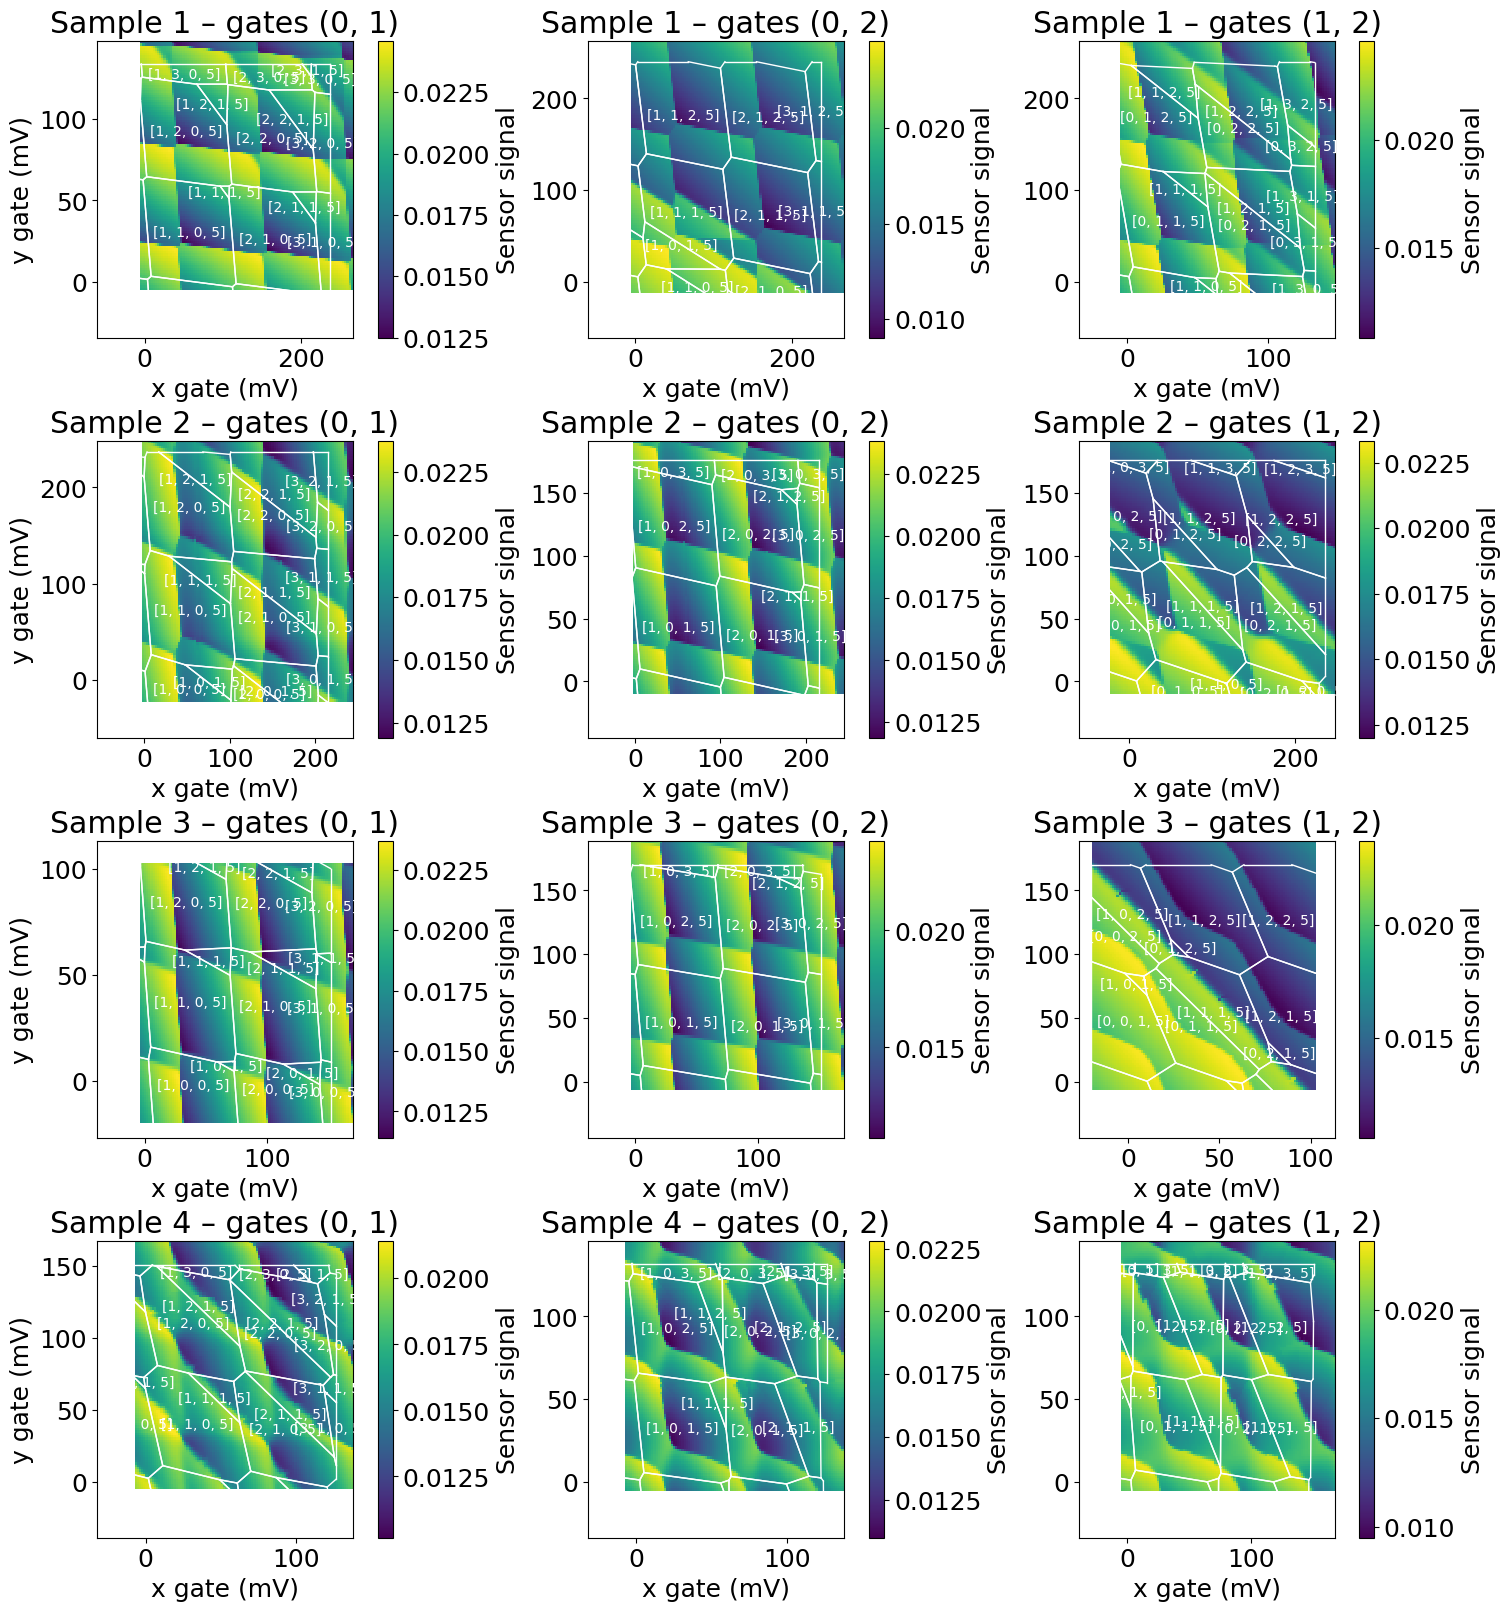

In [ ]:
# HERE WE VISUALISE 4 realisations of the CSD 

fig, axes = plt.subplots(N_samples, len(plane_axis_specs), figsize=(5*len(plane_axis_specs), 4*N_samples),
                         constrained_layout=True)

for sample_idx, sample in enumerate(csd_samples):
    for axis_idx, plane in enumerate(sample["plane_entries"]):
        ax = axes[sample_idx, axis_idx] if N_samples > 1 else axes[axis_idx]
        sensor_signal = plane["sensor_signal"].T
        xout = plane["x_voltages"]
        yout = plane["y_voltages"]
        v1_offset = sample["v1_offset"]
        pair = plane["pair"]
        
        
        pcm = ax.pcolormesh(1e3*xout-1e3*v1_offset[pair[0]],1e3*yout-1e3*v1_offset[pair[1]],sensor_signal)
        
        plot_polytopes(ax, plane["polytopes"], axes_rescale=1e3)  # plot the polytopes to see the constant occupation regions

        if axis_idx == 1:
            ax.set_title(f"Sample {sample_idx+1}")

  
plt.show()
